#### WiDS 2023 datathon 
*a prediction task involving forecasting sub-seasonal temperatures*

# EDA through data visualisation
>This notebook contains miscellaneous python plotting functions to draw out features of data distributed over time and space. This is not meant to be a comprehensive exploration of a particular dataset. It's just a gathering together of helpful code created during the datathon that might be applicable to similar datasets with a few modifications.

### The Data
Kaggle WiDS 2023 dataset.  ie 2 full years of data from 514 locations.  

The training dataset consists of 245 features:-
- location specific data: anonymised latitude and longitude, elevation, climate classification
- global data : daily time series of climate features eg sea surface temperature, sea ice concentration, ENSO index, zonal wind etc
- local time series : daily weather features and monthly forcasts relating to wind, precipitation, humidity, temperature etc

This 500MB+ dataset is not included here. Visit the [Kaggle competition data page](https://www.kaggle.com/competitions/widsdatathon2023/data) for further information and to download a copy.  

And finally..  
Generating multiple plots can take a few seconds with the full dataset. I reccomend using a sample while testing things out if you are impatient.

JW 9/3/23

### [1. Get the Data](#1)


### [2. Spatial Distributions](#2)
2.1 Multiple features by location  
2.2 Distribution of climate region categories  
2.3 Monthly means by location

### [3. Temporal Distributions](#3)
3.1 Multiple time series  
3.2 Offsets from a smoothed global mean

### [4. Features](#4)
4.1 Multiple small histograms  
4.2 Multiple small time series, histograms and box plots


In [1]:
import numpy as np 
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches

import seaborn as sns

In [2]:
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# styling
h1 = {'fontsize': 18, 'va': 'top'}
h4 = {'fontsize': 10, 'style': 'italic','alpha': 0.8}

plt.style.use('ww.mplstyle')

# limit display to 2 dp
pd.options.display.float_format = '{:,.2f}'.format

# pick some colours
theme_c = {'fg' : '#2233FF', 'ot': 'darkorange', 'bg': '#CCCCCC'}

#coolwarm = mpl.colormaps['coolwarm'].resampled(9)
#coolwarm

## <a class="anchor" id="1">1. Get the data</a>

In [3]:
# full kaggle dataset available from https://www.kaggle.com/competitions/widsdatathon2023/data
input_train = "data/train_data.csv"  

train = pd.read_csv(input_train, index_col=["index"], parse_dates=["startdate"], infer_datetime_format=True) 
train.info()

target = 'contest-tmp2m-14d__tmp2m'

<class 'pandas.core.frame.DataFrame'>
Int64Index: 375734 entries, 0 to 375733
Columns: 245 entries, lat to wind-vwnd-925-2010-20
dtypes: datetime64[ns](1), float64(240), int64(3), object(1)
memory usage: 705.2+ MB


Round latitude and longitude to 3dp for easier comparison and nicer display. (There are small, probably floating point error differences between the kaggle test and train datasets)

In [4]:
def round_latlon(X):
    X_ = X.copy()
    X_['lat'] = round(X_['lat'], 3)
    X_['lon'] = round(X_['lon'], 3)
    return X_

train = round_latlon(train)

print("Sample data:")
train.iloc[:3,:6]

Sample data:


lat  lon  startdate  contest-pevpr-sfc-gauss-14d__pevpr  \
index                                                            
0     0.00 0.83 2014-09-01                              237.00   
1     0.00 0.83 2014-09-02                              228.90   
2     0.00 0.83 2014-09-03                              220.69   

       nmme0-tmp2m-34w__cancm30  nmme0-tmp2m-34w__cancm40  
index                                                      
0                         29.02                     31.64  
1                         29.02                     31.64  
2                         29.02                     31.64

## <a class="anchor" id="2">2. Spatial Distributions</a>

### 2.1  How do features vary by location?
The latitudes and longitudes provided have been anonymised so can't be placed on a map. However they can still be plotted in space to give some insight into how the features are distributed.  

In this plot the features represent different kinds of things - temperature, precipitation, wind speed etc. The colour scale is normalised independently for each feature so we can see how each varies. The colour bar is normalised between 0 and 1 for reference.

Sample data:
   lat  lon  gauss-14d__pevpr    hgt-10  sig995-14d__rhum
0 0.00 0.83            275.46 31,076.55             73.70
1 0.00 0.87            271.21 31,078.41             74.97
2 0.04 0.83            297.23 31,078.48             69.22


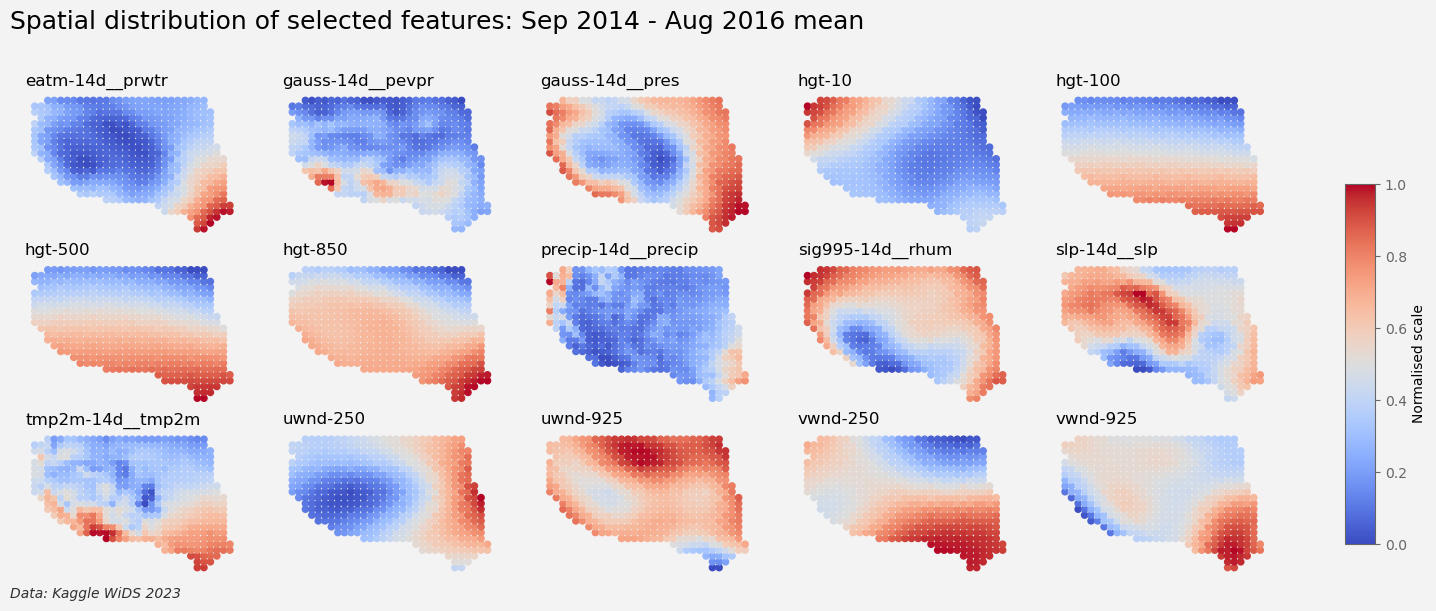

In [5]:
def plot_feats_by_loc(df, title):
# plot small multiples showing spatial distributions of all features
    features = list(set(df.columns) - set(['lat','lon']))
    features.sort()
    n = len(features)
    cols = 5
    rows = (n-1)//cols + 1

    fig, axs = plt.subplots(rows, cols, squeeze=False, figsize=(15,2*rows), sharey=True, sharex=True)

    for i, feature in enumerate(features):
        row, col = i//cols, i%cols
        
        axs[row,col].scatter(x=df['lon'], y = df['lat'], c=df[feature], s=20, cmap='coolwarm')
        axs[row,col].set_title(feature, fontsize=12)
        axs[row,col].set_axis_off()
        
    fig.subplots_adjust(.02,.05,.85,.85)
    
   # indicative colorbar to show normalised scale
    cax = fig.add_axes([.9,.1,.02,.6])
    cmap = mpl.cm.coolwarm
    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),cax=cax, label='Normalised scale')
    
    fig.text(.01,.99,title, fontdict=h1) 
    fig.text(.01,.01,"Data: Kaggle WiDS 2023", fontdict=h4) 
    return fig

    
# select some features to display
features = [x for x in train.columns if x.split('-')[0] == 'contest'] 

# set up the plot data: lat, lon and selected features averaged over time
df = train[['lat','lon'] + features].groupby(['lat','lon']).mean().reset_index()
# reduce length of wids23 feature names for nicer plotting
df.rename(columns = {feature:'-'.join(feature.split('-')[-2:]) for feature in features}, inplace=True)

print("Sample data:")
print(df.iloc[:3,:5])

fig = plot_feats_by_loc(df, title="Spatial distribution of selected features: Sep 2014 - Aug 2016 mean")
plt.savefig("vis/A1_spatial_contest_feat_mean.jpg") 
plt.show()

#### Observations
- The sites are gridded 
- There are clear spatial patterns to most features
- The prediction target (tmp2m-14d__tmp2m) shows more complex variation by location than most of these features (on average). 
- 14d__wind-hgt-100 and 14d__wind-hgt-500 on average seem to vary largely by latitude alone and show similar spatial distributions. Consider removing from analysis.

Sample data:
   lat  lon  gauss-14d__pevpr    hgt-10  sig995-14d__rhum
0 0.00 0.83         11,860.37 39,952.74             56.45
1 0.00 0.87         11,930.84 40,457.06             47.06
2 0.04 0.83         16,230.80 47,626.80             71.51


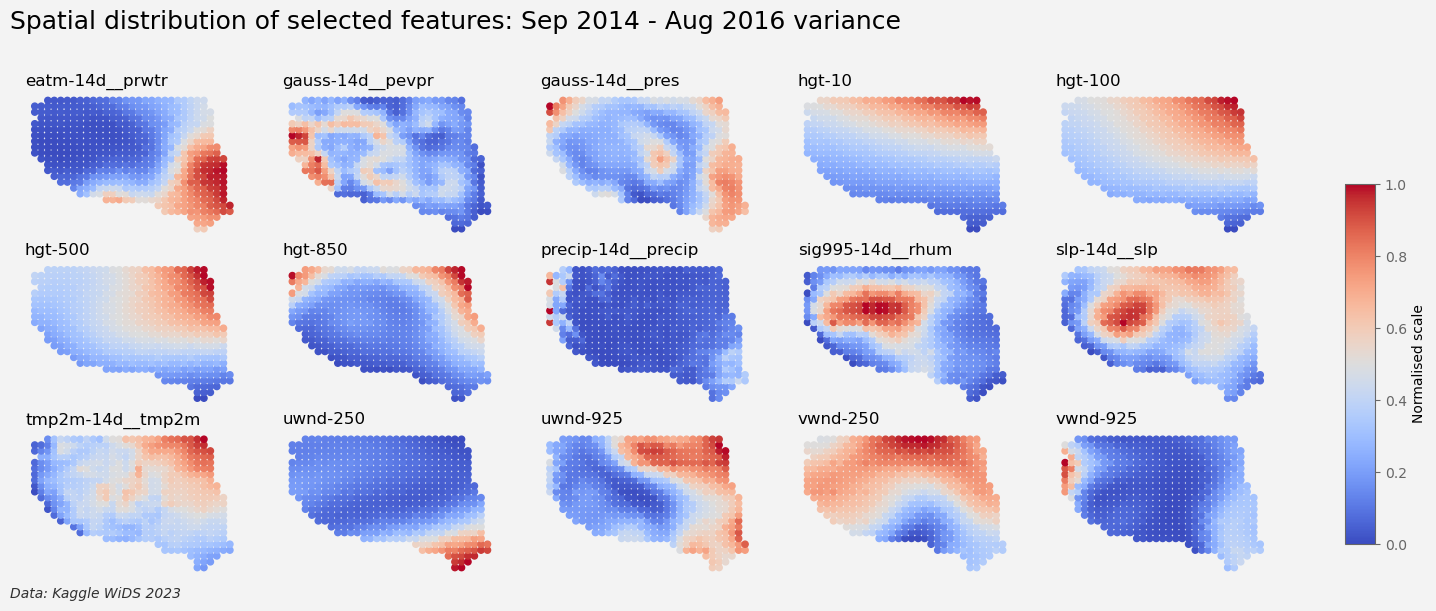

In [6]:
# set up the plot data: lat, lon and variance of selected features over time
df = train[['lat','lon'] + features].groupby(['lat','lon']).var().reset_index()
# reduce length of wids23 feature names for nicer plotting (take last components)
df.rename(columns = {feature:'-'.join(feature.split('-')[-2:]) for feature in features}, inplace=True)
print("Sample data:")
print(df.iloc[:3,:5])

fig = plot_feats_by_loc(df, title="Spatial distribution of selected features: Sep 2014 - Aug 2016 variance")
plt.savefig("vis/A1_spatial_contest_feat_var.jpg")
plt.show()

- Features vary over time differently according to location. For example the prediction target (tmp2m-14d__tmp2m) is most variable in the north east and least variable in the far west. Prediction may be easier in the far west locations.

### 2.2 How are the climateregion categories distributed?

There are several discrete features in the dataset to explore but only one based on location - climate classification. 

sample data:
    lat  lon climateregions__climateregion
0 0.00 0.83                           BSh
1 0.00 0.87                           Cfa
2 0.04 0.83                           Cfa


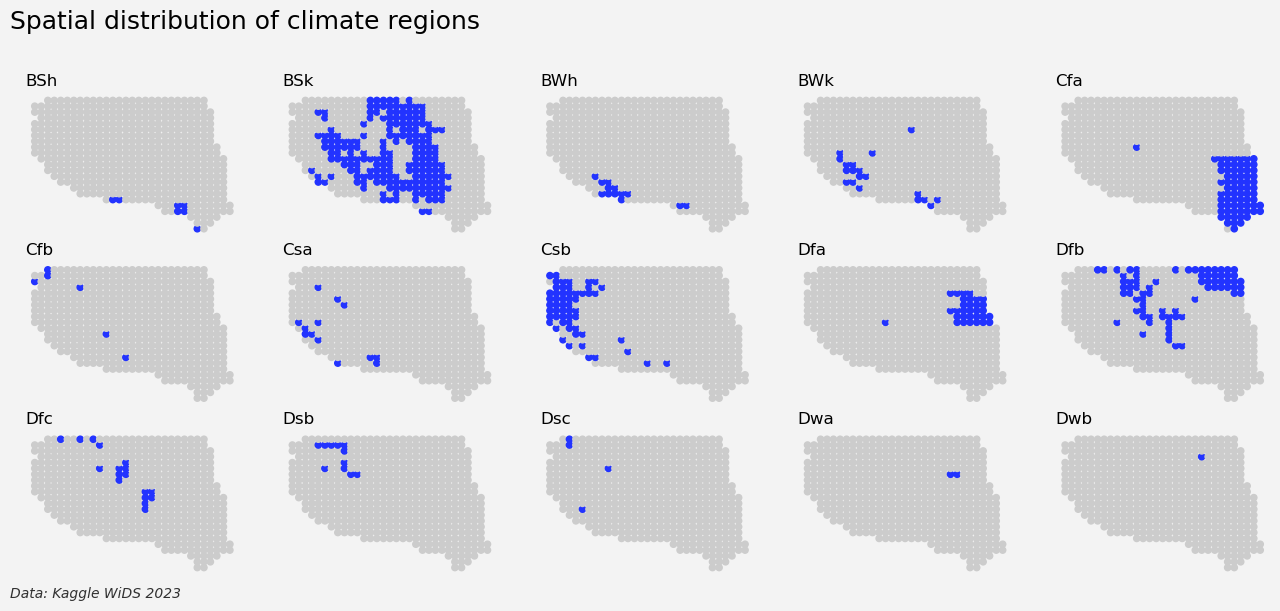

In [7]:
def plot_cats_by_loc(df, f_cat, title):
# plot small multiples to show spatial distribution of categories
    categories = df[f_cat].unique()
    categories.sort()
    n = len(categories)
    cols = 5
    rows = (n-1)//cols + 1

    fig, axs = plt.subplots(rows,cols, squeeze=False, figsize=(15,2*rows), sharey=True, sharex=True)

    for i, cat in enumerate(categories):
        # create colour feature
        df['colour'] = [theme_c['bg']] * len(df)
        df.loc[df.loc[:,f_cat] == cat, 'colour'] = theme_c['fg']
        
        row, col = i//cols, i%cols
        axs[row,col].scatter(x=df['lon'], y = df['lat'], c=df['colour'], s=20)
        axs[row,col].set_title(cat, fontsize=12)
        axs[row,col].set_axis_off()
    
    fig.subplots_adjust(.02,.05,.85,.85)
    fig.text(.01,.99,title, fontdict=h1) 
    fig.text(.01,.01,"Data: Kaggle WiDS 2023", fontdict=h4) 
    return fig
    

# set up the data: lat, lon and category
df = train[['lat','lon','climateregions__climateregion']].groupby(['lat','lon','climateregions__climateregion']).mean().reset_index()
print("sample data:\n",df.head(3))

plot_cats_by_loc(df, 'climateregions__climateregion', title="Spatial distribution of climate regions")
plt.savefig("vis/A1_climateregion_distn.jpg")
plt.show()

#### Observations
- The categories vary considerably in size. BSk dominates. Dwa, Dwb are very small. Small categories will need to be combined to create data subsets stratified by climateregion.
- Climate regions tend to be clustered geographically though several consist of a number of 'islands'. eg Dfc.  
- Some locations are categorised differently to all their nearest neighbours. Are these anomalous?
- The general climate category distribution shares some features with the mean temperature distributon. eg Dfc locations tend to be the coldest, BWh the hottest.

### 2.3 How does the target vary geographically across the year

Here I'm trying to get a big picture view of the target variable in both space and time with small multiples.

sample data:

startdate    10    11    12  lat  lon
0         24.33 17.30 15.29 0.00 0.83
1         24.20 17.81 15.89 0.00 0.87
2         24.10 16.64 14.40 0.04 0.83


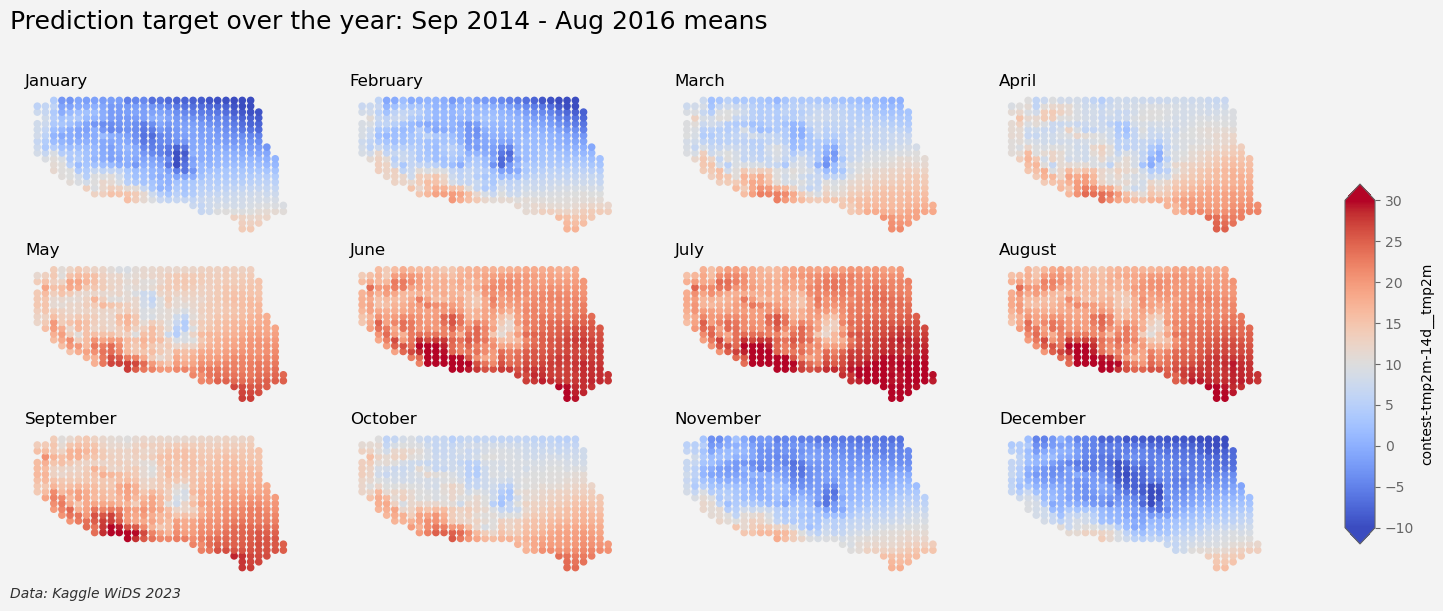

In [8]:
def plot_mm_by_loc(df, title, vmin=-10, vmax=30):
# Plot small multiples to show spatial distribution of a feature for each month 
# Similar to plot_feats_by_loc but has a shared colour scale across the plots
# The colour scale can be adjusted by setting vmin and vmax
    n = 12
    cols = 4
    rows = (n-1)//cols + 1

    fig, axs = plt.subplots(rows, cols, squeeze=False, figsize=(15,2*rows), sharey=True, sharex=True)

    months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    for i, month in enumerate(months):
        row, col = i//cols, i%cols
        
        locs = axs[row,col].scatter(x=df['lon'], y = df['lat'], c=df[i+1], s=20, cmap='coolwarm', vmin=vmin, vmax=vmax)
        axs[row,col].set_title(month, fontsize=12)
        axs[row,col].set_axis_off()
        
    fig.subplots_adjust(.02,.05,.85,.85)
    
    cax = fig.add_axes([.9,.1,.02,.6])
    fig.colorbar(locs, cax=cax, label=target, extend='both')
    
    fig.text(.01,.99,title, fontdict=h1) 
    fig.text(.01,.01,"Data: Kaggle WiDS 2023", fontdict=h4) 
    return fig


def get_latlon_mm(X, feature):
# create dataframe of lat, lon and monthly means of feature
    grps = X.groupby(['lat','lon'])

    records = []
    for latlon, grp in grps:
        # calculate monthly mean
        mm = grp.groupby(grp['startdate'].dt.month)[feature].mean()
        mm['lat'], mm['lon'] = latlon
        records.append(mm)
    return pd.DataFrame(records).reset_index(drop=True)


# set up the data - lat, lon and monthly means
df = get_latlon_mm(train[['lat','lon','startdate',target]], target)

print("sample data:\n")
print(df.iloc[:3,-5:])

plot_mm_by_loc(df, title="Prediction target over the year: Sep 2014 - Aug 2016 means")
plt.savefig("vis/A1_spatial_monthly_mean.jpg")
plt.show()

#### Observations
- As expected there are clear seasonal variations with warmer summer months and cooler winter months
- Some of the small climateregions categories do not stand out on these plots. Consider combining these with larger categories eg Dwa and Dwb with neighbouring categories.
- The Dfc and BWh categories looks to align with marked temperature features. They may be useful predictors. 

sample data:

startdate   10   11    12  lat  lon
0         3.87 5.55 11.40 0.00 0.83
1         2.76 5.98 10.93 0.00 0.87
2         4.25 5.79 11.30 0.04 0.83


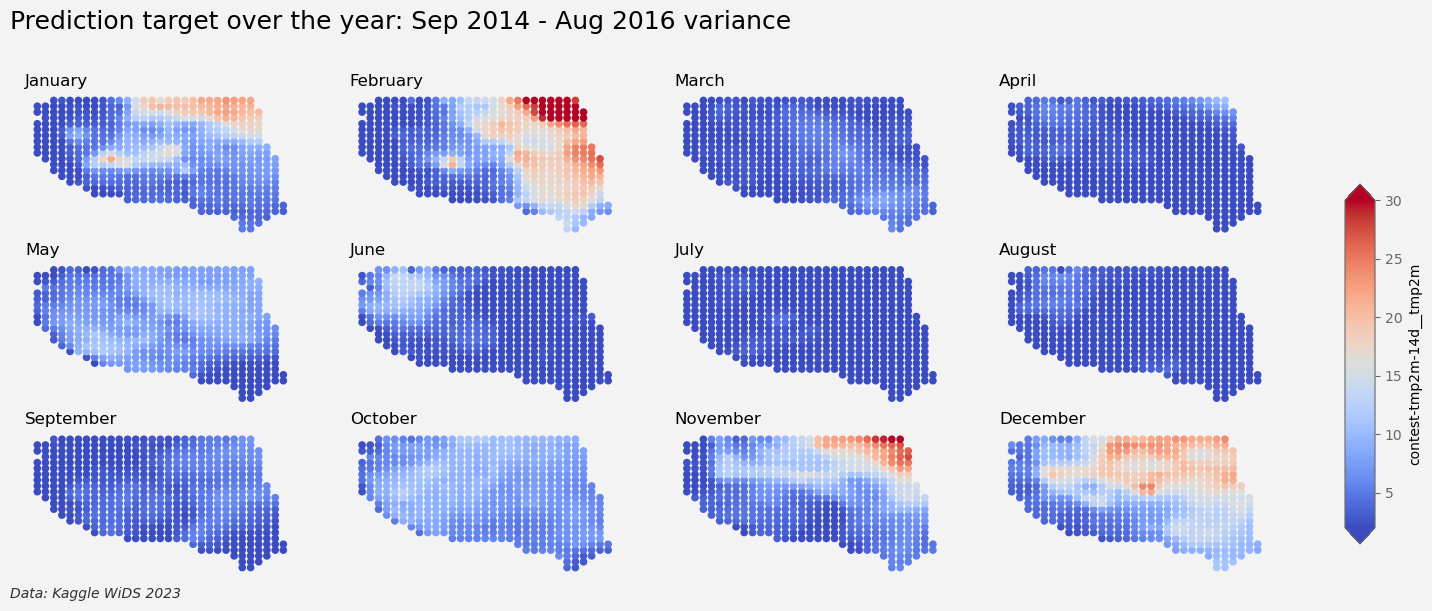

In [9]:
def get_latlon_mv(X, feature):
# create dataframe of lat, lon and monthly variance of feature
    grps = X.groupby(['lat','lon'])

    records = []
    for latlon, grp in grps:
        # calculate monthly variance
        mm = grp.groupby(grp['startdate'].dt.month)[feature].var()
        mm['lat'], mm['lon'] = latlon
        records.append(mm)
    return pd.DataFrame(records).reset_index(drop=True)

# set up the data - lat, lon and monthly variance of prediction target
df = get_latlon_mv(train[['lat','lon','startdate',target]], target)

print("sample data:\n")
print(df.iloc[:3,-5:])

plot_mm_by_loc(df, title="Prediction target over the year: Sep 2014 - Aug 2016 variance", vmin=2, vmax=30)
plt.savefig("vis/A1_spatial_monthly_var.jpg")
plt.show()

- The winter months have the highest variance, particularly in the north east. Swings in the target variable may make prediction harder in winter than in the summer months which have low variance. Consider impact on chosen evaluation dataset.

## <a class="anchor" id="3">3. Temporal Distributions</a>

### 3.1 How does the prediction target vary over time?

There are 514 locations in the full dataset. To get a high level overview they have all been plotted on one chart. So many lines can make it hard to see patterns so the global mean and a couple of contrasting locations have been picked out. 

sample data: 
            glob_mean  (0.0, 0.833)  (0.0, 0.867)
startdate                                        
2014-09-01      18.16         28.74         28.45
2014-09-02      18.02         28.37         28.16
2014-09-03      17.92         28.13         28.06


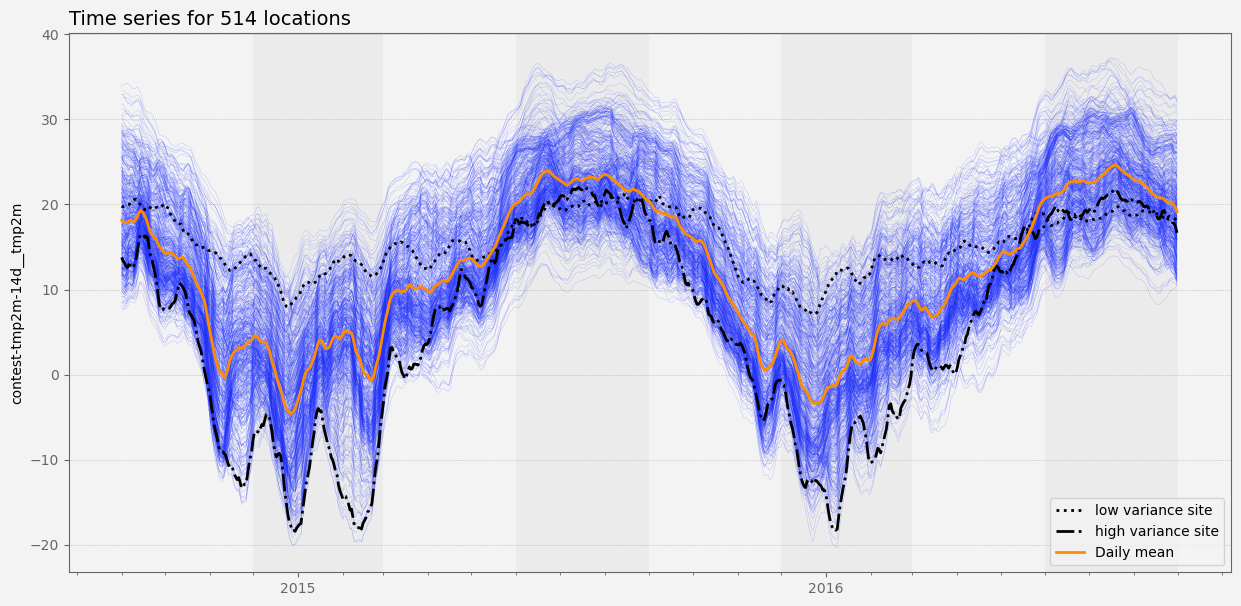

In [10]:
def ts_by_loc(X, feature):
# return dataframe of feature time series for each lat/lon and the global mean    
    dat = {}
    dat['glob_mean'] = X.groupby(['startdate'])[feature].mean()
    grps = X.groupby(['lat','lon'])
    for latlon, ts in grps:
        dat[latlon] = pd.Series(data=ts[feature].values, index = ts['startdate'])
    return pd.DataFrame(dat)

def plot_feat_ts(X, feature, gm=False, lw=.1):
# plot feature time series for each lat/lon in X     
# use a thin line if many time series to show
    df = ts_by_loc(X, feature)
    print("sample data: ")
    print(df.iloc[:3,:3])
    
    ax.plot(df, lw=lw, c=theme_c['fg'], alpha=.8) # use a thin line and small alpha if many time series to show
    # highlight a couple of contrasting sites
    ax.plot(df[[(0.455, 0.067)]], c='k', lw=2, ls=':', label="low variance site")
    ax.plot(df[[(0.955, 0.867)]], c='k', lw=2,  ls='-.', label="high variance site")
    
    if gm:
        ax.plot(df['glob_mean'], lw=2, c=theme_c['ot'], alpha=1, label="Daily mean")
    ax.legend(loc='lower right')
        
    # grid and labels
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
     
    for yr in (2014, 2015):
        # mark the seasons
        ax.axvspan(dt.datetime(yr,12,1),dt.datetime(yr+1,3,1), facecolor=theme_c['bg'], alpha=0.2)
        ax.axvspan(dt.datetime(yr+1,6,1),dt.datetime(yr+1,9,1), facecolor=theme_c['bg'], alpha=0.2)
    ax.grid(True, 'major', 'y', ls=':', lw=.5, c='k', alpha=.3)
    
    num_locs = len(df.columns) -1
    ax.set_title("Time series for " + str(num_locs) + " locations")
    ax.set_ylabel(feature)
    return ax


fig, ax = plt.subplots(figsize=(15,7))
ax = plot_feat_ts(train[['lat','lon','startdate',target]], target, gm=True)
plt.savefig("vis/A1_ts_multi.jpg")
plt.show()

#### Observations
- As expected there is clear seasonality with summer peaks and winter troughs. 
- Superimposed on the roughly sinusoidal annual pattern are smaller peaks and troughs with a similar pattern seen across many locations. Predicting these will be important for subseasonal (in this case fortnightly) forecasts. 
- Some of the troughs appear to lag slightly at some locations. eg Nov 2014.

### 3.2 Exploring transformations - subtracting the global mean

To see more clearly variations from the usual, a smoothed daily time series of global mean values was calculated (ie averaged across all locations). This was subtracted from the feature data to produce an offset.  

Note if applying as part of a machine learning process to the target feature, consider fitting with training data only to avoid target data leakage. 

sample data: 
            glob_mean  (0.0, 0.833)  (0.0, 0.867)
startdate                                        
2014-09-01      -1.34          9.25          8.95
2014-09-02      -1.36          9.00          8.79
2014-09-03      -1.33          8.88          8.81


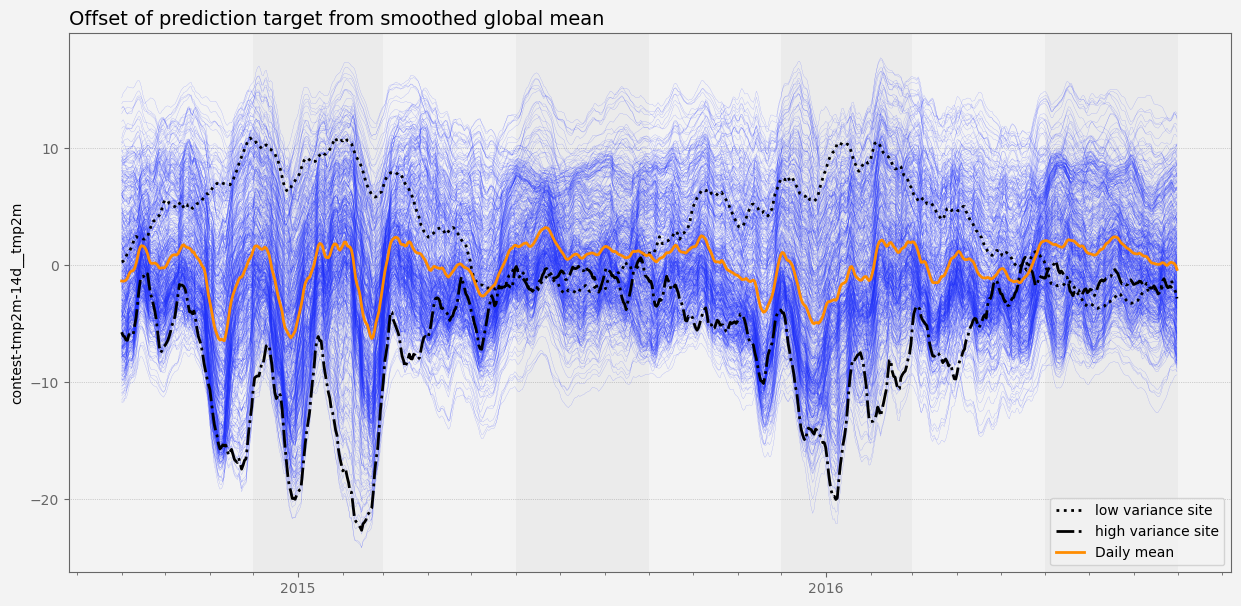

In [11]:
class Offset():
# Create offset time series by subtracting smoothed mean values across locations for each day of year
# Needs at least 1 full year of data for transform
    def fit(self, X, y):
        var = y.name
        Xy = pd.concat([X,y], axis=1)
        y_glob = Xy.groupby(X['startdate'])[var].mean()
        y_glob = y_glob.rolling(100, center=True).mean() # smoothed mean
        self.daily_means_ = y_glob.groupby(y_glob.index.dayofyear).mean() # calc daily averages
        if len(self.daily_means_)==365:
            self.daily_means_.loc[366] = self.daily_means_.loc[365] # for leap year
        return self

    def transform(self, X,y):
        return y - self.daily_means_.loc[X['startdate'].dt.dayofyear].values
    
    def inverse(self, X, y):
        return y + self.daily_means_.loc[X['startdate'].dt.dayofyear].values


X = train[['lat','lon','startdate']]
y = train[target]
oy = Offset()

# calculate smoothed time series of daily global means
oy.fit(X,y) 
# subtract the mean to produce an offset
offset_y = oy.transform(X,y)


# plot out the resulting offset time series
offset_Xy = pd.concat([X, offset_y], axis=1)

fig, ax = plt.subplots(figsize=(15,7))
ax = plot_feat_ts(offset_Xy, target, gm=True)
ax.set_title("Offset of prediction target from smoothed global mean")
plt.savefig("vis/A1_ts_offset.jpg")
plt.show()

#### Observations
- The greatest variation in the prediction target is in winter. There are some sharp troughs, particularly winter 14/15
- The range of values is up to approx 35 degrees in winter and 25 degrees in summer
- Sites with similar summer temperatures can vary by 30 degrees in winter
Consider time series splits for evaluation of models. Summer months may not be very representative of winter target months and result in overly optimistic scores.

## <a class="anchor" id="4">4. Features</a>

### 4.1 What shape are the feature distributions?
There are 245 features in this dataset so I wanted a high level view to see the bigger picture.

['contest-pevpr-sfc-gauss-14d__pevpr', 'contest-wind-h10-14d__wind-hgt-10', 'contest-rhum-sig995-14d__rhum', 'contest-wind-h100-14d__wind-hgt-100', 'contest-tmp2m-14d__tmp2m', 'contest-slp-14d__slp', 'contest-wind-vwnd-925-14d__wind-vwnd-925', 'contest-pres-sfc-gauss-14d__pres', 'contest-wind-uwnd-250-14d__wind-uwnd-250', 'contest-prwtr-eatm-14d__prwtr', 'contest-wind-vwnd-250-14d__wind-vwnd-250', 'contest-precip-14d__precip', 'contest-wind-h850-14d__wind-hgt-850', 'contest-wind-uwnd-925-14d__wind-uwnd-925', 'contest-wind-h500-14d__wind-hgt-500']


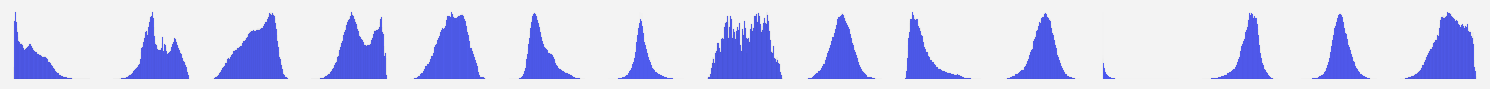

In [12]:
def plot_histograms(X):
    n = len(X.columns)
    cols = 15
    rows = (n-1)//cols + 1
    
    fig, axs = plt.subplots(rows,cols, squeeze=False, figsize=(15, rows*1))
    [ax.set_axis_off() for ax in axs.ravel()]
    for i, var in enumerate(X.columns):
        row = i//cols
        col = i%cols
        axs[row,col] = sns.histplot(X[var], ax=axs[row,col], color=theme_c['fg'])
                                               
    plt.tight_layout()
    
df = train[features]
print(features)
plot_histograms(df)
plt.savefig("vis/A1_feat_hist.jpg")
plt.show()

['nmme0-prate-56w__cancm30', 'nmme0-prate-56w__cancm40', 'nmme0-prate-56w__ccsm30', 'nmme0-prate-56w__ccsm40', 'nmme0-prate-56w__cfsv20', 'nmme0-prate-56w__gfdlflora0', 'nmme0-prate-56w__gfdlflorb0', 'nmme0-prate-56w__gfdl0', 'nmme0-prate-56w__nasa0', 'nmme0-prate-56w__nmme0mean', 'nmme0-prate-34w__cancm30', 'nmme0-prate-34w__cancm40', 'nmme0-prate-34w__ccsm30', 'nmme0-prate-34w__ccsm40', 'nmme0-prate-34w__cfsv20', 'nmme0-prate-34w__gfdlflora0', 'nmme0-prate-34w__gfdlflorb0', 'nmme0-prate-34w__gfdl0', 'nmme0-prate-34w__nasa0', 'nmme0-prate-34w__nmme0mean']


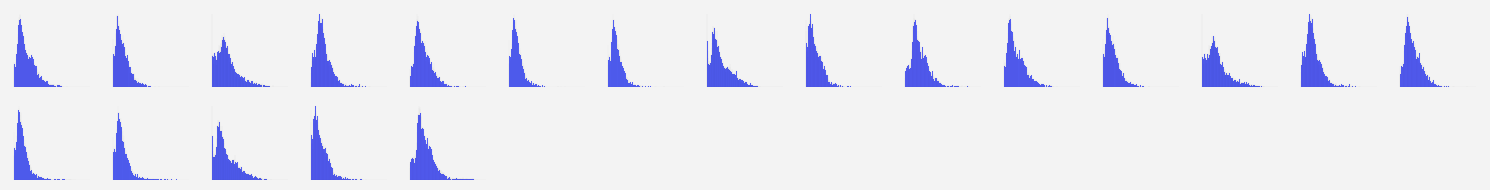

In [13]:
features = [x for x in train.columns if x[:7] == 'nmme0-p']
print(features)
plot_histograms(train[features])
plt.show()

#### Observations
- Some of these features are skewed and would probably benefit from a transformation to a more 'normal' distribution
- Some of these features look bimodal eg contest-wind-h100-14d__wind-hgt-100

### 4.2 How do the features vary in time and space?
Here I've added a time series highlighting the daily mean against a background of the values at each location.  

In [14]:
def plot_histplot(feature, ax):
    sns.histplot(feature, ax=ax, color=theme_c['fg'])
    return ax

def plot_cumplot(feature, ax):
    sns.ecdfplot(feature, ax=ax, color=theme_c['fg'])
    return ax

def plot_boxplot(feature, ax):
    sns.boxplot(x=feature, ax=ax, color=theme_c['bg'])
    return ax

def plot_feature_ts(X, feature, ax):
    grps = X.groupby(['startdate'])
    feature_avg = grps[feature].mean() # daily mean
    x = feature_avg.index.values # np dt array
    y = feature_avg.values
    mean = np.mean(X[feature])
    
    ax.scatter(x=X['startdate'], y = X[feature], c=theme_c['bg'], alpha=0.1, label="data") # all data
    ax.scatter(x=x, y = y, c=theme_c['fg'], s=5, alpha=.3, label="daily mean") # daily averages
    
    ax.axhline(y = mean, color='k',ls='--')
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.set_title(feature,loc='right')
    return ax

def plot_features(X, features):
    rows = len(features)
    
    fig, axs = plt.subplots(rows,4, squeeze=False, figsize=(15, rows*1.25))
    for i, feature in enumerate(features):
        axs[i,0] = plot_feature_ts(X, feature, axs[i,0])
        axs[i,1] = plot_histplot(X[feature], ax=axs[i,1])
        axs[i,2] = plot_cumplot(X[feature], ax=axs[i,2])
        axs[i,3] = plot_boxplot(X[feature], ax=axs[i,3])
                                               
    plt.tight_layout()

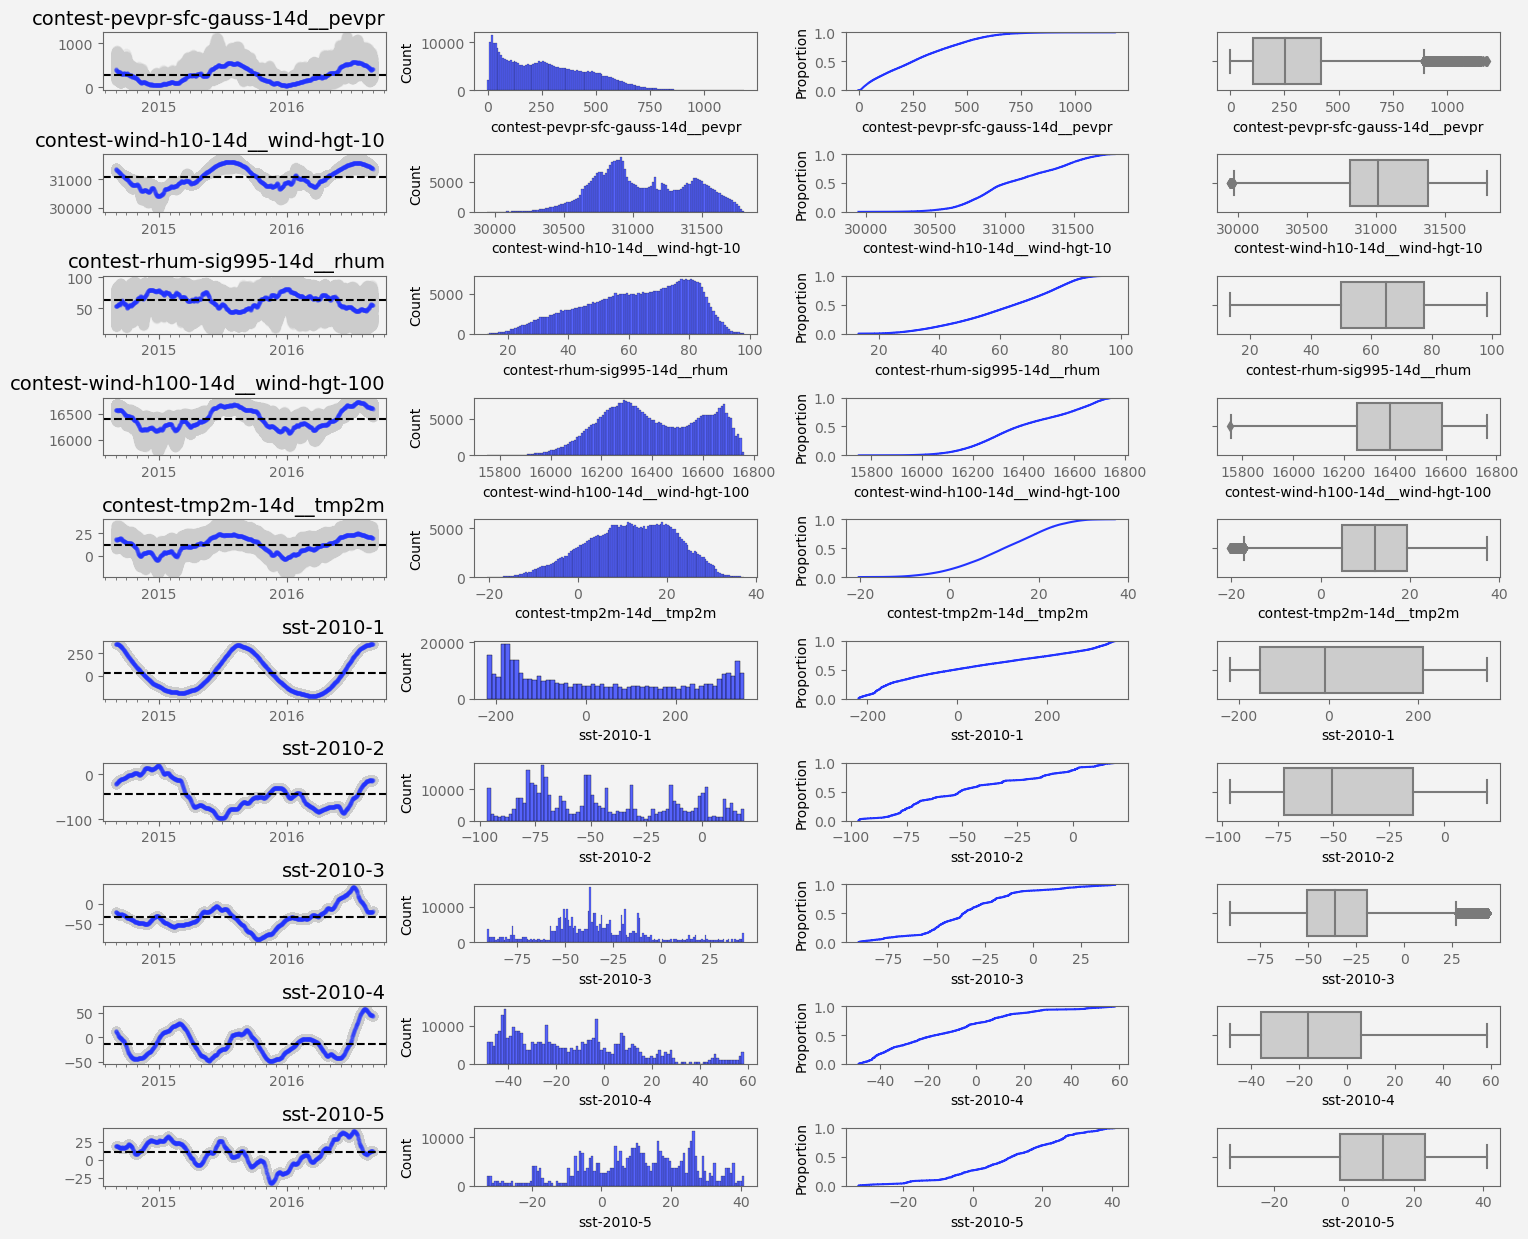

In [15]:
# select some features
f_contest = [x for x in train.columns if x.split('-')[0] == 'contest']
f_sst = [x for x in train.columns if x.split('-')[0] == 'sst']
features = f_contest[:5] + f_sst[:5]

plot_features(train, features)
plt.savefig("vis/A1_feat_dist.jpg")
plt.show()

#### Observations

- rhum varies a lot with location. wind-hgt-10, not so much
- The sst features don't vary at all with location 
- The boxplots help idemtify features with a lot of outliers eg sst-2010-3

## Final thoughts

Trying to visualise this dataset in time and space really helped me to get my head round it. I love the blend of science and art involved in data visualisation and am always interested to see new ways to do it well.

As to the competition? I went down a lot of blind alleys and barely improved on my initial Xgboost - throw it all in - model. But I learned alot along the way and hopefully I'll be quicker off the mark next time. Well done to the winners!